## Quick validation of network modules

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core_acc_modules import paths

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Examine size of modules

In [2]:
corr_threshold_list = [0.9, 0.8, 0.7, 0.6, 0.5]

for corr_threshold in corr_threshold_list:
    print(f"Modules using correlation threshold: {corr_threshold}")
    pao1_membership_filename = f"pao1_membership_{corr_threshold}.tsv"
    pa14_membership_filename = f"pa14_membership_{corr_threshold}.tsv"

    pao1_membership = pd.read_csv(
        pao1_membership_filename, sep="\t", header=0, index_col=0
    )
    pa14_membership = pd.read_csv(
        pa14_membership_filename, sep="\t", header=0, index_col=0
    )

    print(pao1_membership["module id"].value_counts())
    print(pa14_membership["module id"].value_counts())

Modules using correlation threshold: 0.9
0.0    4530
1.0     244
2.0     170
3.0     149
4.0     127
5.0     106
6.0      84
7.0      70
8.0      51
9.0      32
Name: module id, dtype: int64
0.0    5192
1.0     391
2.0     120
3.0      81
4.0      37
6.0      35
5.0      35
Name: module id, dtype: int64
Modules using correlation threshold: 0.8
0.0     3165
1.0     1060
2.0      536
3.0      197
4.0      120
5.0       82
6.0       75
7.0       49
8.0       42
9.0       38
10.0      36
11.0      35
12.0      34
13.0      32
14.0      32
15.0      30
Name: module id, dtype: int64
0.0     3600
1.0      828
2.0      191
3.0      116
4.0       82
6.0       80
5.0       80
7.0       72
8.0       66
9.0       65
10.0      62
11.0      59
13.0      46
12.0      46
14.0      44
15.0      44
18.0      42
16.0      42
17.0      42
19.0      40
20.0      38
21.0      37
22.0      36
23.0      36
24.0      34
25.0      32
26.0      31
Name: module id, dtype: int64
Modules using correlation threshold

In [3]:
# plotting function
def plot_dist_modules(threshold_list):

    # Set up the matplotlib figure
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(len(threshold_list)):
        pao1_membership_filename = f"pao1_membership_{threshold_list[i]}.tsv"
        pa14_membership_filename = f"pa14_membership_{threshold_list[i]}.tsv"

        pao1_membership = pd.read_csv(
            pao1_membership_filename, sep="\t", header=0, index_col=0
        )
        pa14_membership = pd.read_csv(
            pa14_membership_filename, sep="\t", header=0, index_col=0
        )

        # Get bins using all data
        hist, bins_corr = np.histogram(
            np.concatenate([pao1_membership["module id"], pa14_membership["module id"]])
        )

        # Distribution plot for core genes
        fig = sns.distplot(
            pao1_membership["module id"],
            label="PAO1 modules",
            color="red",
            bins=bins_corr,
            kde=False,
            ax=axes[i],
        )

        fig = sns.distplot(
            pa14_membership["module id"],
            label="PA14 modules",
            color="blue",
            bins=bins_corr,
            kde=False,
            ax=axes[i],
        )

        fig.set_title(
            f"Histogram of size of modules using threshold {threshold_list[i]}",
            fontsize=12,
        )
        handles, labels = fig.get_legend_handles_labels()
        fig.legend(handles, labels, loc="center right")

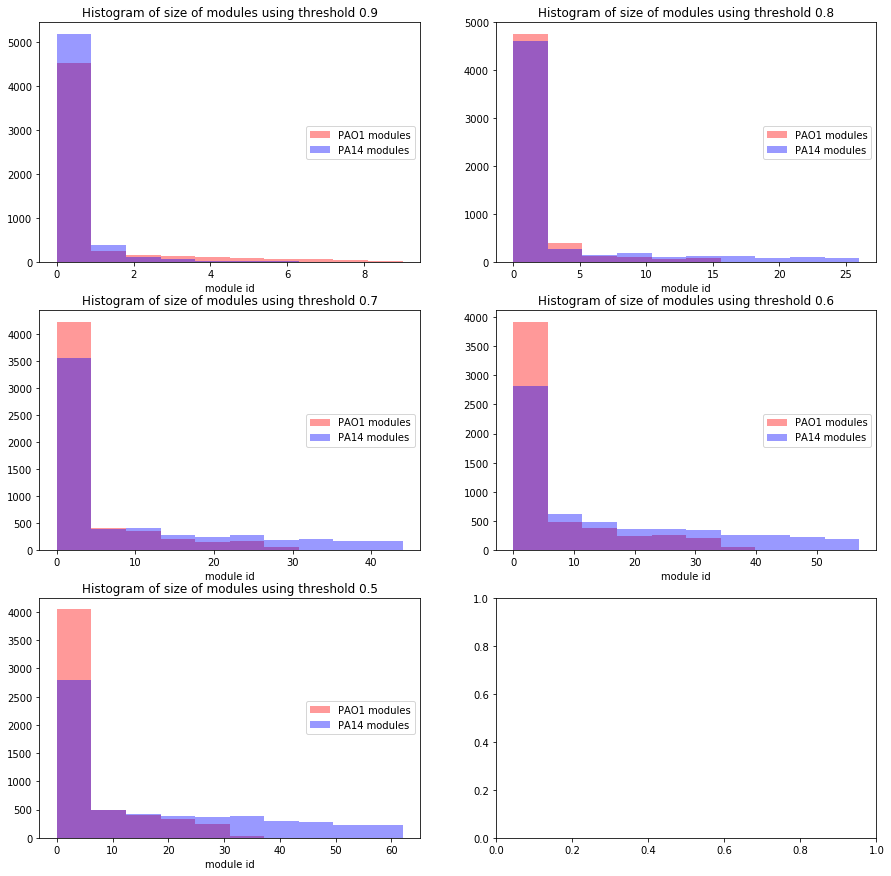

In [4]:
# Plot distribution of modules per threshold
plot_dist_modules(corr_threshold_list)

## Examine composition of modules

We expect that genes within the same operon or regulon will cluster together (i.e. be within the same module). To test this we will compare the distribution of the number of modules that contain genes within the same regulon vs the number of modules that contain random genes

In [5]:
# Load PAO1 regulon and operon file
pao1_regulon_filename = paths.PAO1_REGULON
pao1_operon_filename = paths.PAO1_OPERON

# Load membership for specific threshold
corr_threshold = 0.9
pao1_membership_filename = f"pao1_membership_{corr_threshold}.tsv"

pao1_membership = pd.read_csv(pao1_membership_filename, sep="\t", header=0, index_col=0)

In [6]:
pao1_membership.head()

,module id
PA0001,0.0
PA0002,0.0
PA0003,0.0
PA0004,0.0
PA0005,0.0


In [7]:
# Parse file
pao1_operon = pd.read_csv(pao1_operon_filename, index_col=0, header=0)
print(pao1_operon.shape)
pao1_operon.head()

(3257, 2)


,Length,Genes
OperonID,,
12029,4,PA0001;PA0002;PA0003;PA0004
12030,2,PA0005;PA0006
12031,2,PA0008;PA0009
12032,3,PA0016;PA0017;PA0018
12033,2,PA0021;PA0022


In [8]:
# For each regulon/operson, select a random set of genes that are the same size at the regulon/operon
pao1_operon["Random Genes"] = pao1_operon["Length"].apply(
    lambda num_genes: pao1_membership.sample(num_genes).index.values
)

In [9]:
pao1_operon.head()

,Length,Genes,Random Genes
OperonID,,,
12029,4,PA0001;PA0002;PA0003;PA0004,"[PA3307, PA5113, PA0332, PA5278]"
12030,2,PA0005;PA0006,"[PA1630, PA4089]"
12031,2,PA0008;PA0009,"[PA4379, PA1538]"
12032,3,PA0016;PA0017;PA0018,"[PA1684, PA4544, PA2164]"
12033,2,PA0021;PA0022,"[PA4076, PA3310]"


In [10]:
pao1_operon["Genes"] = pao1_operon["Genes"].str.split(";")

In [11]:
pao1_operon.head()

,Length,Genes,Random Genes
OperonID,,,
12029,4,"[PA0001, PA0002, PA0003, PA0004]","[PA3307, PA5113, PA0332, PA5278]"
12030,2,"[PA0005, PA0006]","[PA1630, PA4089]"
12031,2,"[PA0008, PA0009]","[PA4379, PA1538]"
12032,3,"[PA0016, PA0017, PA0018]","[PA1684, PA4544, PA2164]"
12033,2,"[PA0021, PA0022]","[PA4076, PA3310]"


In [41]:
# Need to deal with genes not in membership list
pao1_operon["Genes"].apply(
    lambda list_genes: pao1_membership.loc[list_genes]["module id"].nunique()
)

/home/alexandra/anaconda3/envs/core_acc_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


KeyError: "None of [Index(['PA2319'], dtype='object')] are in the [index]"

In [40]:
pao1_membership.loc[pao1_operon.loc[12029, "Genes"]]["module id"].nunique()

1

In [45]:
pao1_membership.shape
"PA2319" in list(pao1_membership.index)
# pao1_membership['PA2319']

False

In [ ]:
# For each regulon/operon get the number of modules that regulon/operon genes are found in, number of modules
# that random genes are found in

In [ ]:
# Compare distributions using t-test